In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import time
import ipywidgets as wg
from ipywidgets import interact
from IPython.display import display
import networkx as nx
from src.environment import Environment
from src.runner import runner
from src.helpers import confidence_interval
from sklearn import preprocessing
import random
import json

In [2]:
style.use('seaborn-white')

### 1 load general the parameters

In [3]:
with open('parameters/parameters.json') as json_file:
    parameters = json.load(json_file)

parameters['data_output'] = 'network'

## 2 load district data
### 2.1 general neighbourhood data

In [4]:
population = pd.read_csv('input_data/population.csv')
with open('parameters/district_data.json') as json_file:
    districts_data = json.load(json_file)

### 2.2 age data

In [5]:
age_distribution = pd.read_csv('input_data/age_dist.csv', sep=';', index_col=0)
age_distribution_per_ward = dict(age_distribution.transpose())

### 2.3 household size distribution

In [6]:
HH_size_distribution = pd.read_excel('input_data/HH_Size_Distribution.xlsx', index_col=0)

### 3 Load travel matrix

In [7]:
travel_matrix = pd.read_csv('input_data/Travel_Probability_Matrix.csv', index_col=0)

### 4 load contact matrices

In [8]:
age_groups = ['age_0_10', 'age_10_20', 'age_20_30', 'age_30_40', 'age_40_50', 
              'age_50_60', 'age_60_70', 'age_70_80', 'age_80_plus']

hh_contact_matrix = pd.read_excel('input_data/ContactMatrices_10year.xlsx', sheet_name="Home", index_col=0)
hh_contact_matrix['80plus'] = hh_contact_matrix['70_80']
row = hh_contact_matrix.xs('70_80')
row.name = '80plus'
hh_contact_matrix = hh_contact_matrix.append(row)
hh_contact_matrix.columns = age_groups
hh_contact_matrix.index = age_groups

In [9]:
other_contact_matrix = pd.read_excel('input_data/ContactMatrices_10year.xlsx', sheet_name="OutsideOfHome", index_col=0)
other_contact_matrix['80plus'] = other_contact_matrix['70_80']
row = other_contact_matrix.xs('70_80')
row.name = '80plus'
other_contact_matrix = other_contact_matrix.append(row)

change column and index names to match other data sources.

In [10]:
other_contact_matrix.columns = age_groups
other_contact_matrix.index = age_groups

The next step is to either run the model in the SABCoModel.py file or run it here in the notebook. When running it in the notebook the initialization starts here. 

# Simulation

In [11]:
data_folder = 'measurement/baseline/'
environment = Environment(0, parameters, districts_data, age_distribution_per_ward,  
                          hh_contact_matrix, other_contact_matrix, HH_size_distribution, travel_matrix)

environment = runner(environment, 0, data_folder=data_folder, data_output='network')

In [12]:
len(environment.network.edges())

87905

### Save network data

In [13]:
for idx, network in enumerate(environment.infection_states):
    for i, node in enumerate(network.nodes):
        network.nodes[i]['agent'] = network.nodes[i]['agent'].status

    nx.write_graphml(network, "measurement/baseline/network_time{}.graphml".format(idx))

### Read data 

In [14]:
infection_states = []
for idx in range(parameters["time"]):
    infection_states.append(nx.read_graphml("measurement/baseline/network_time{}.graphml".format(idx), node_type=int))

In [15]:
susceptible_ot = []
exposed_ot = []
infected_1_ot = []
infected_2_ot = []
critical_ot = []
dead_ot = []
recovered_ot = []

for t in range(parameters['time']):
    network = infection_states[t]
    susceptible = 0
    exposed = 0
    infected_1 = 0
    infected_2 = 0
    critical = 0
    dead = 0
    recovered = 0
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            susceptible += 1
        elif network.nodes[idx]['agent'] == 'e':
            exposed += 1
        elif network.nodes[idx]['agent'] == 'i1':
            infected_1 += 1
        elif network.nodes[idx]['agent'] == 'i2':
            infected_2 += 1
        elif network.nodes[idx]['agent'] == 'c':
            critical += 1
        elif network.nodes[idx]['agent'] == 'd':
            dead += 1
        elif network.nodes[idx]['agent'] == 'r':
            recovered +=1
        else:
            print('no status?')
    
    susceptible_ot.append((susceptible / float(len(network))) * population['Population'].sum())
    infected_1_ot.append((infected_1 / float(len(network))) * population['Population'].sum())
    infected_2_ot.append((infected_2 / float(len(network)))  * population['Population'].sum())
    critical_ot.append((critical / float(len(network)))  * population['Population'].sum())
    dead_ot.append((dead / float(len(network)))  * population['Population'].sum())
    recovered_ot.append((recovered / float(len(network)))  * population['Population'].sum())
    exposed_ot.append((exposed / float(len(network)))  * population['Population'].sum())

(0, 3740030.74811)

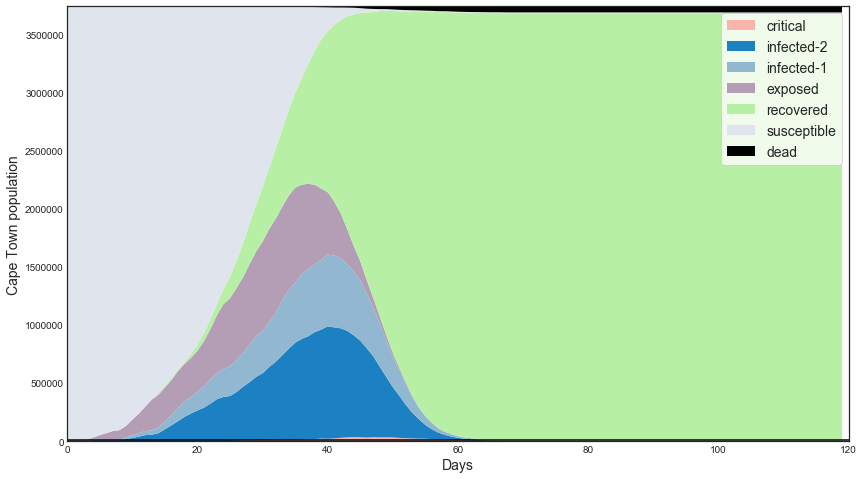

In [16]:
fig, ax = plt.subplots(figsize=(14,8))

x = [x for x in range(parameters['time'])]

labels = ['critical','infected-2', 'infected-1', 'exposed', 'recovered', 'susceptible', 'dead']

y = np.vstack([critical_ot, infected_2_ot, infected_1_ot, exposed_ot, recovered_ot, susceptible_ot, dead_ot])

ax.axhline(parameters['health_system_capacity'] * population['Population'].sum(), color='black')

pal = ["#f9b4ad", "#1b81c2", "#91b7d1", "#b39eb5", "#b7f0a5", "#e0e4ec","#000000"]

ax.stackplot(x, y, colors= pal, labels=labels)
ax.legend(loc='best', fontsize='14', frameon=True)
ax.set_ylabel('Cape Town population', fontsize='14')
ax.set_xlabel('Days', fontsize='14')

plt.xlim([0,parameters['time']])
plt.ylim([0, population['Population'].sum()])

#fig.savefig('measurement/the_curve.png')

In [17]:
print('total_dead = ', dead_ot[-1]/ population['Population'].sum())
print('max critical = ', max(critical_ot) / population['Population'].sum())
print('total_infected = ', (dead_ot[-1] + recovered_ot[-1]) / population['Population'].sum())

total_dead =  0.0138
max critical =  0.0096
total_infected =  0.9979999999999999


In [18]:
import collections

In [19]:
degree_sequence = sorted([d for n, d in environment.network.degree()], reverse=True)  # degree sequence 
degreeCount = collections.Counter(degree_sequence)

In [20]:
degreeCount

Counter({75: 1,
         69: 1,
         68: 4,
         67: 3,
         66: 8,
         65: 6,
         64: 9,
         63: 16,
         62: 17,
         61: 18,
         60: 21,
         59: 16,
         58: 24,
         57: 27,
         56: 31,
         55: 33,
         54: 39,
         53: 39,
         52: 45,
         51: 65,
         50: 74,
         49: 64,
         48: 73,
         47: 100,
         46: 118,
         45: 113,
         44: 151,
         43: 142,
         42: 152,
         41: 164,
         40: 164,
         39: 158,
         38: 167,
         37: 188,
         36: 182,
         35: 171,
         34: 203,
         33: 213,
         32: 171,
         31: 191,
         30: 166,
         29: 168,
         28: 153,
         27: 131,
         26: 126,
         25: 97,
         24: 82,
         23: 92,
         22: 82,
         21: 55,
         20: 48,
         19: 53,
         18: 38,
         17: 37,
         16: 29,
         15: 23,
         14: 28,
         13: 29,

In [21]:
degree_sequence

[75,
 69,
 68,
 68,
 68,
 68,
 67,
 67,
 67,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 65,
 65,
 65,
 65,
 65,
 65,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 64,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 61,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,


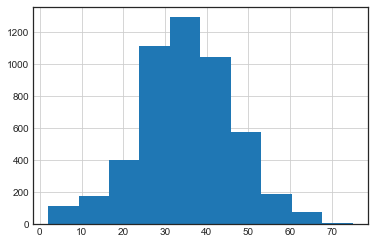

In [22]:
pd.Series(degree_sequence).hist()

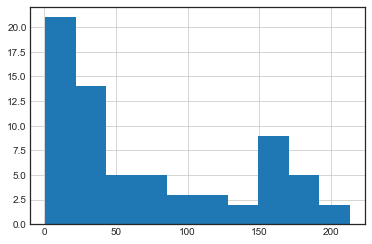

In [23]:
pd.Series(degreeCount).hist()

## Draw

In [24]:
pos = nx.spring_layout(infection_states[0])

In [25]:
def plot_model(t):
    network = infection_states[t]
    color_map = []
    for idx, node in enumerate(network):
        if network.nodes[idx]['agent'] == 's':
            color_map.append('blue')
        elif network.nodes[idx]['agent'] == 'e':
            color_map.append('pink')
        elif network.nodes[idx]['agent'] == 'i1':
            color_map.append('purple')
        elif network.nodes[idx]['agent'] == 'i2':
            color_map.append('red')
        elif network.nodes[idx]['agent'] == 'c':
            color_map.append('brown')
        elif network.nodes[idx]['agent'] == 'd':
            color_map.append('black')
        elif network.nodes[idx]['agent'] == 'r':
            color_map.append('grey')
    nx.draw(network, pos=pos, node_color=color_map, with_labels=True)

In [26]:
time_period = wg.IntSlider(description='Time step', min=0, max=parameters['time']-1)
wg.interact(plot_model, t=time_period)

interactive(children=(IntSlider(value=0, description='Time step', max=119), Output()), _dom_classes=('widget-i…

<function __main__.plot_model(t)>